In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/imagenet-50-splits/train"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Testing set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19525 files belonging to 50 classes.
Using 15620 files for training.
Found 19525 files belonging to 50 classes.
Using 3905 files for validation.


In [4]:
def img_transforms(data,label):
    # start_time = time.time()
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    # print("time to normalize: ", time.time()-start_time)
    # start_time = time.time()
    gray_img = tf.image.rgb_to_grayscale(data)
    # print("time to gray: ", time.time()-start_time)
    gray_norm_img = normalize_img(gray_img)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE

train_ds_preprocessed = train_ds.map(img_transforms)#,num_parallel_calls=AUTOTUNE)
val_ds_preprocessed = val_ds.map(img_transforms)#,num_parallel_calls=AUTOTUNE)

CASHE_Train = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/CASHE_TrainResNet"
CASHE_Val = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/CASHE_ValResNet"
train_ds_preprocessed = train_ds_preprocessed.cache(CASHE_Train).prefetch(buffer_size=AUTOTUNE)
val_ds_preprocessed = val_ds_preprocessed.cache(CASHE_Val).prefetch(buffer_size=AUTOTUNE)

In [ ]:
idx = 0
start_time = time.time()
for t in train_ds_preprocessed:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

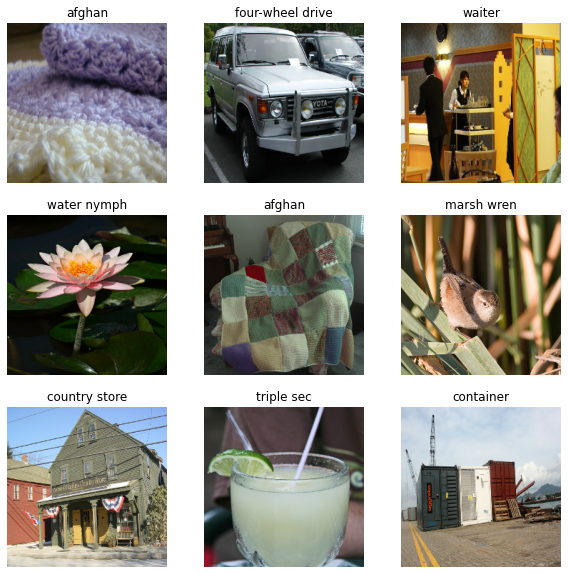

In [ ]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

### Dual Stream ResNet Architecture

In [5]:
from keras.backend import dropout
class DualStream_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None, 
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.magno_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        
        self.parvo_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.magno_stream.trainable = False
          self.parvo_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(2048,activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)
        
        p_stream = self.parvo_stream(concat_gray_input)
        p_stream = self.flat(p_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([p_stream,m_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([p_stream,m_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

In [ ]:
FREEZE = False 
LOAD_WEIGHTS = None #One of None or imagenet
dual_stream_model = DualStream_ResNet(50,batch_size,FREEZE,load_type=LOAD_WEIGHTS,
                                      merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
checkpoint_path = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models//content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_ResNet2.0"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 4)
dual_stream_model.save("/Models/Dualstream_with_ResNet3.0")

Epoch 1/30
489/489 [==============================] - 375s 744ms/step - loss: 8.3791 - accuracy: 0.0213 - val_loss: 3.9118 - val_accuracy: 0.0179
Epoch 2/30
489/489 [==============================] - 361s 738ms/step - loss: 3.9219 - accuracy: 0.0213 - val_loss: 3.9120 - val_accuracy: 0.0207
Epoch 3/30
489/489 [==============================] - 362s 739ms/step - loss: 3.9184 - accuracy: 0.0222 - val_loss: 3.9450 - val_accuracy: 0.0246
Epoch 4/30
489/489 [==============================] - 361s 738ms/step - loss: 3.9187 - accuracy: 0.0275 - val_loss: 3.9007 - val_accuracy: 0.0269
Epoch 5/30
489/489 [==============================] - 377s 770ms/step - loss: 3.9111 - accuracy: 0.0274 - val_loss: 3.9800 - val_accuracy: 0.0325
Epoch 6/30
489/489 [==============================] - 359s 734ms/step - loss: 3.9009 - accuracy: 0.0300 - val_loss: 3.8503 - val_accuracy: 0.0307
Epoch 7/30
489/489 [==============================] - 361s 737ms/step - loss: 3.8249 - accuracy: 0.0431 - val_loss: 4.0164 -

INFO:tensorflow:Assets written to: /Models/Dualstream_with_ResNet3.0/assets


INFO:tensorflow:Assets written to: /Models/Dualstream_with_ResNet3.0/assets


In [ ]:
#Load Model:
dual_stream_model = tf.keras.models.load_model("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_ResNet2.0")
dual_stream_model.layers[0].summary()
dual_stream_model.evaluate(val_ds_preprocessed)

### Simple ResNet architectur test

In [ ]:
#Testing Pure ResNet Model Training
from keras.backend import dropout
class Single_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None, 
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.magno_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.magno_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([#tf.keras.layers.Dense(2048,activation='ReLU'),
                              #tf.keras.layers.Dropout(0.5),
                              # tf.keras.layers.Dense(1280, activation='ReLU'),
                              # tf.keras.layers.Dropout(0.5),
                              # tf.keras.layers.Dense(640, activation='ReLU'),
                              # tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)

        return self.fc(m_stream)

In [ ]:
FREEZE = True 
LOAD_WEIGHTS = "imagenet" #One of None or imagenet
signle_resnet_model = Single_ResNet(50,batch_size,FREEZE,load_type=LOAD_WEIGHTS,
                                      merge_type="averaging")
signle_resnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

train_history = signle_resnet_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 4)
signle_resnet_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Single_ResNet")

Epoch 1/30
489/489 [==============================] - 113s 224ms/step - loss: 7.4113 - accuracy: 0.0967 - val_loss: 7.6407 - val_accuracy: 0.0786
Epoch 2/30
489/489 [==============================] - 174s 355ms/step - loss: 5.5213 - accuracy: 0.1840 - val_loss: 6.3371 - val_accuracy: 0.1429
Epoch 3/30
489/489 [==============================] - 174s 355ms/step - loss: 5.5426 - accuracy: 0.2143 - val_loss: 6.8760 - val_accuracy: 0.1770
Epoch 4/30
489/489 [==============================] - 173s 354ms/step - loss: 4.7822 - accuracy: 0.2669 - val_loss: 6.7313 - val_accuracy: 0.1439
Epoch 5/30
489/489 [==============================] - 174s 355ms/step - loss: 4.8375 - accuracy: 0.2880 - val_loss: 5.9217 - val_accuracy: 0.1762
Epoch 6/30
489/489 [==============================] - 174s 355ms/step - loss: 4.3708 - accuracy: 0.3245 - val_loss: 7.1372 - val_accuracy: 0.1572
Epoch 7/30
489/489 [==============================] - 174s 355ms/step - loss: 4.3802 - accuracy: 0.3396 - val_loss: 6.8962 -

### DualStream with VGG versions

### DualStream EfficientNet Architecture
(limitation: it overfits really badly on our current dataset. The literature reports overfitting when smaller training sets are given as a serious issue with EffectiveNet)

In [8]:
import tensorflow as tf
                                                                                
class DualStream_ENet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None,
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.magno_stream = tf.keras.applications.EfficientNetB0(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=self.n_outputs,
                            classifier_activation="softmax",
                            )
        
        self.parvo_stream = tf.keras.applications.EfficientNetB0(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=self.n_outputs,
                            classifier_activation="softmax",
                            )
        if freeze:
          self.magno_stream.trainable = False
          self.parvo_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(2048,activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()
        self.fc_out = tf.keras.layers.Dense(self.n_outputs, activation='softmax')

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        # start_time = time.time()
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)
        # print("delta_time:",time.time()-start_time)

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)
        
        p_stream = self.parvo_stream(concat_gray_input)
        p_stream = self.flat(p_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([p_stream,m_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([p_stream,m_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

In [15]:
FREEZE = False #One of None or imagenet
dual_stream_model = DualStream_ENet(50,batch_size,FREEZE,load_type="imagenet",
                                    merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# checkpoint_path = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models//content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_ResNet2.0"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 4)
dual_stream_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_EfficientNet_Deeper")

Epoch 1/30
489/489 [==============================] - 348s 671ms/step - loss: 2.9101 - accuracy: 0.3179 - val_loss: 5.7237 - val_accuracy: 0.0133
Epoch 2/30
489/489 [==============================] - 325s 663ms/step - loss: 2.3374 - accuracy: 0.4244 - val_loss: 19.3927 - val_accuracy: 0.0190
Epoch 3/30
489/489 [==============================] - 325s 663ms/step - loss: 2.2102 - accuracy: 0.4646 - val_loss: 44.7883 - val_accuracy: 0.0207
Epoch 4/30
489/489 [==============================] - 325s 664ms/step - loss: 2.2732 - accuracy: 0.4535 - val_loss: 13.0702 - val_accuracy: 0.0228
Epoch 5/30
489/489 [==============================] - 324s 662ms/step - loss: 2.1662 - accuracy: 0.4679 - val_loss: 4.0507 - val_accuracy: 0.0251
Epoch 6/30
489/489 [==============================] - 324s 661ms/step - loss: 2.1699 - accuracy: 0.4697 - val_loss: 136.9688 - val_accuracy: 0.0182
Epoch 7/30
489/489 [==============================] - 324s 662ms/step - loss: 2.3259 - accuracy: 0.4434 - val_loss: 5.0

### Exploring different types of architecture:

In [ ]:
#VGG architecture with no pre-loaded weights

out_classes = 10

Magno_VGG_16 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten()
])

Parvo_VGG_8 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten()
])

fc_end = Sequential([
    Average(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=out_classes, activation="softmax")
])